<a href="https://colab.research.google.com/github/kuneus/Matrix-Factorization-Book-Recommendation-System/blob/main/c964_capstone.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **INTRODUCTION**

This notebook is part of the submission for WGU's C964 - Computer Science Capstone. This project implements a book recommendation system using matrix factorization under the collaborative filtering model. Collaborative filtering is the most common model for recommendation systems, which uses data from a similar user to generate recommendations for the user of interest. This filtering method requires a dataset that includes user IDs, book titles, and user ratings.

Matrix factorization is an algorithm used in recommendation systems to reduce large user-item interaction matrices into smaller components that reveal hidden patterns. In this case, the user-item matrix has the users as rows, book titles as columns, and the table values as user ratings.

For this model, we will use a specific type of matrix factorization called singular value decompression (SVD). This technique decomposes the user-item matrix into smaller matrices, capturing the most essential relationships between users and items. By reducing the matrix's dimensionality, SVD can generate highly accurate recommendations.

This notebook is broken down into the following steps:

1. Import libraries
2. Load dataset
3. Data preparation
4. Model implementation
5. Model evaluation
5. Visualizations
6. User Interface


# **1. IMPORT LIBRARIES**

First, we will import the necessary libraries and modules.

In [ ]:
!pip install scikit-surprise

# data processing
import pandas as pd

#data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# SVD implementation
from surprise import SVD, Dataset, Reader, accuracy
from surprise.model_selection import train_test_split, cross_validate

# evaluation metrics
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix

# directory management
import glob
import os


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.4/154.4 kB 4.8 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.4-cp311-cp311-linux_x86_64.whl size=2505182 sha256=0537fc20e021a032c933cb073920cae7473cd7849d9e54a7bf8002c660713b0d
  Stored in directory: /root/.cache/pip/wheels/2a/8f/6e/7e2899163e2d85d8266daab4aa1cdabec7a6c56f83c015b5af
Successfully built scikit-surprise


# **2. LOAD DATASET**

Then, we need to download and load the dataset. For this project, the Goodreads Book Datasets with User Rating 2M was used from Kaggle. The link for this dataset can be reached [here](hhttps://www.kaggle.com/datasets/bahramjannesarr/goodreads-book-datasets-10m/data). This dataset includes 2 primary datasets: books dataset and user ratings dataset. For this project, only the user ratings dataset is needed. Initially, this dataset was split into 7 files. I took the liberty to merge them into a single file and uploaded it to my Google Drive.

The following code cell downloads the dataset from my Google Drive and loads it into a dataframe.

In [ ]:
# download the dataset from google drive link
!gdown https://drive.google.com/uc?id=1tI6xwkA2UL2Kd5ylr9FAoA7HWcHy58ou -O user_ratings.csv

user_ratings_df = pd.read_csv("/content/user_ratings.csv")


Downloading...
From: https://drive.google.com/uc?id=1tI6xwkA2UL2Kd5ylr9FAoA7HWcHy58ou
To: /content/user_ratings.csv
100% 18.5M/18.5M [00:00<00:00, 91.1MB/s]


# **3. DATA PREPARATION**

Start with cleaning the data by erasing null values and removing duplicates.

In [ ]:
# drop null values
user_ratings_df = user_ratings_df.dropna()

# drop duplicate values for users with duplicate ratings for the same book
user_ratings_df = user_ratings_df.drop_duplicates(subset=['ID', 'Name'])

# drop rows without any rating -- this wouldn't be picked up by dropping null
# values since all ratings are in text format, including null ratings
user_ratings_df = user_ratings_df[user_ratings_df["Rating"] != "This user doesn't have any rating"
]

Next, format the data. Since the user ratings are text descriptions, this needs to be converted to numerical values.

In [ ]:
# define mapping from text to numerical ratings
numerical_rating = {
    "it was amazing": 5,
    "really liked it": 4,
    "liked it": 3,
    "it was ok": 2,
    "did not like it": 1
}

# convert text rating into numerical rating
user_ratings_df["Rating"] = user_ratings_df["Rating"].replace(numerical_rating)

# convert column to integer type
user_ratings_df["Rating"] = user_ratings_df["Rating"].astype(int)

# rename columns for clarity
user_ratings_df.rename(columns={"ID":"User_Id"}, inplace=True)
user_ratings_df.rename(columns={"Rating":"User_Rating"}, inplace=True)


<ipython-input-4-7b62e0c4ad58>:11: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  user_ratings_df["Rating"] = user_ratings_df["Rating"].replace(numerical_rating)


Then, prepare the dataset for singular value decompression. This involves defining the rating scale for the model and filtering the data frame by dropping users with less than 5 ratings.

In [ ]:
# define rating scale of 1 to 5 to be consistent with the book rating scale
reader = Reader(rating_scale=(1,5))

# count number of ratings per user
user_rating_counts = user_ratings_df["User_Id"].value_counts()

# keep only users with at least 5 ratings
num_ratings_threshold = 5
filtered_users = user_rating_counts[user_rating_counts >= num_ratings_threshold].index
filtered_df = user_ratings_df[user_ratings_df["User_Id"].isin(filtered_users)]

print(f"Original dataset size: {len(user_ratings_df)}")
print(f"Filtered dataset size: {len(filtered_df)}")


Original dataset size: 357396
Filtered dataset size: 355529


# **4. MODEL IMPLEMENTATION**

Now for implementing the model. Here, we create a surprise dataset from the filtered data frame. Then we split the dataset into training and testing sets. The training set will comprise 80% of the filtered dataset and the testing set will comprise the remaining 20%. The training set is used to train the model and the testing set will be used to evaluate the model's performance.

In [ ]:
# create a surprise dataset. Surprise creates a user-item matrix internally
data = Dataset.load_from_df(filtered_df[['User_Id', 'Name', 'User_Rating']], reader)

# training dataset will comprise 80%, testing dataset will comprise 20%
trainset, testset = train_test_split(data, test_size=0.2, random_state=42)

# initialize model
svd_model = SVD()

# train model
svd_model.fit(trainset)

# use testing dataset to evaluate predictions
predictions = svd_model.test(testset)

# **5. MODEL EVALUATION**

For model evaluation, root mean square error (RMSE) and mean absolute error (MAE) are used to measure error. Precision, recall, and F1-score are used to measure the model's accuracy.

RMSE takes the testing dataset as the actual ratings and the model output data as the predicted ratings, then measures the square root of the average squared differences between the two. MAE calculates the average absolute error between the two datasets. Thus, both metrics measure the error between the model’s prediction and the test data.

Precision is a metric that measures the accuracy of positive predictions. Recall measures how well a model identifies all positive instances. F1-score is defined as the harmonic mean of the two.

To measure the accuracy metrics, the ratings need to be split into binary classifications of "like" and "dislike". For this project, the "like" threshold is set at 3 and anything below is considered a "dislike".

In [ ]:
# evaluate with RMSE and MAE
rmse = accuracy.rmse(predictions)
mae = accuracy.mae(predictions)

# for precision, recall, and f1-score, split ratings into binary
# classifications of "like" and "dislike" by setting a threshold for "like"
# and "dislike"
threshold = 3

y_true = [1 if true_r >= threshold else 0 for (_, _, true_r, _, _) in predictions]
y_pred = [1 if pred_r >= threshold else 0 for (_, _, _, pred_r, _) in predictions]

# compute precision, recall, and f1-score
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)

RMSE: 0.8862
MAE:  0.7028


Print all metrics together

In [ ]:
# model performance with threshold = 3
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1:.4f}")

RMSE: 0.8862
MAE: 0.7028
Precision: 0.9166
Recall: 0.9598
F1-score: 0.9377


# **6. VISUALIZATIONS**

For data visualizations, I've included a scatterplot of average ratings per user, a confusion matrix, and a histogram of absolute error. *italicized text*

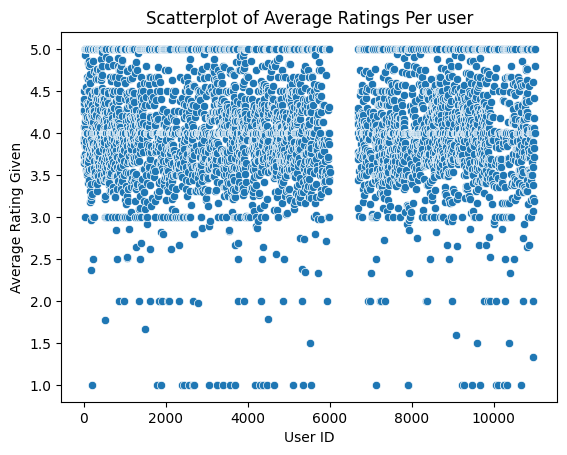

In [ ]:
# computer avg rating for each user
user_avg_ratings = user_ratings_df.groupby("User_Id")["User_Rating"].mean()

# scatterplot of user id vs average rating
sns.scatterplot(x=user_avg_ratings.index, y=user_avg_ratings.values)

plt.xlabel("User ID")
plt.ylabel("Average Rating Given")
plt.title("Scatterplot of Average Ratings Per user")
plt.show()

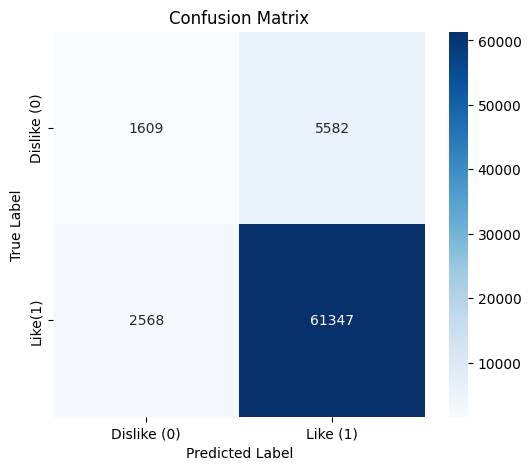

In [ ]:
# generate confusion matrix
cm = confusion_matrix(y_true, y_pred)

# plot confusion matrix
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Dislike (0)", "Like (1)"], yticklabels=["Dislike (0)", "Like(1)"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

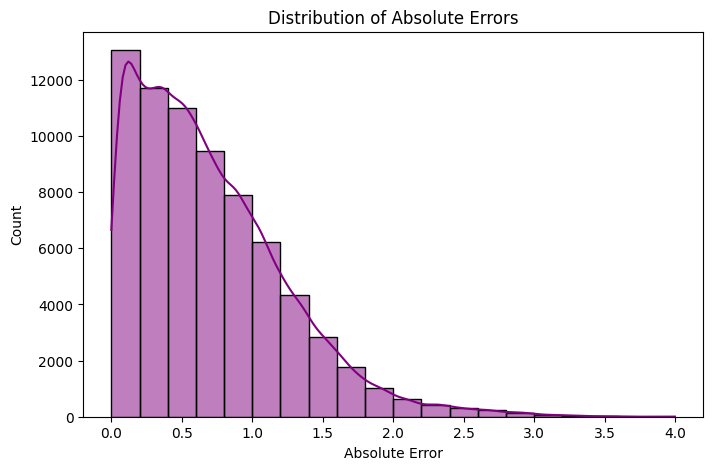

In [ ]:
# calculate absolute errors
errors = [abs(true_r - pred_r) for (_, _, true_r, pred_r, _) in predictions]

# plot histogram for distribution of errors
plt.figure(figsize=(8,5))
sns.histplot(errors, bins=20, kde=True, color='purple')

plt.xlabel("Absolute Error")
plt.ylabel("Count")
plt.title("Distribution of Absolute Errors")
plt.show()

# **7. USER INTERFACE**


This is a simple command line user interface. Through the interace, the user can find a user ID, request a number of book recommendations, receive recommendations, and quit the program.

In [ ]:
# function to generate book recommendations
def recommend_books(user_id, model, n=10):
  # get books that the user hasn't rated yet
  unrated_books = user_ratings_df[~user_ratings_df['Name'].isin(user_ratings_df[user_ratings_df['User_Id'] == user_id]['Name'])].copy()

  # predict ratings for unseen books
  unrated_books['Predicted_Rating'] = unrated_books['Name'].apply(lambda x: model.predict(user_id, x).est)

  # sort by predicted rating and get top N recommendations
  top_recommendations = unrated_books[['Name', 'Predicted_Rating']].sort_values(by='Predicted_Rating', ascending=False)

  # drop duplicates of book titles
  top_recommendations = top_recommendations.drop_duplicates(subset=['Name'], keep='first')

  # return list of the top n recommendations
  return top_recommendations['Name'].head(n).tolist()

# search user id to check if it exists in the dataset
def get_user_id(user_id):
  if int(user_id) in user_ratings_df['User_Id']:
    return True
  else:
    return False

def main():
  print("Welcome to the Book Nexus Recommendation System!")
  print("Use this system to generate the top book recommendations for any user!")
  print("---------------------------------------------------------------------")

  # run loop until user quits program
  while True:
    # get user's ID
    user_id = input("Enter your user ID or enter 'q' to exit program:  ")

    # check if user wants to close the program.
    if user_id == 'q':
      print('Exiting program.')
      break

    # validate user id
    try:
      user_id = int(user_id)

      # if user ID is found, get number of recommendations next
      if get_user_id(user_id):
        # run loop until valid recommendation input
        while True:
          n_recommendations = input("Enter the number of recommendations you want:  ")
          try:
            n_recommendations = int(n_recommendations)

            # generate book recommendations
            book_list = recommend_books(user_id, svd_model, n=n_recommendations)

            print(f"\nHere are the top {n_recommendations} book recommendations for user #{user_id}:\n")

            # print each book recommendation
            for n in range(0,n_recommendations):
              print(f"{n+1}. {book_list[n]}\n")

            print("---------------------------------------------------------------------")

            break
          except ValueError:
            print("Invalid input. Please enter a number.")

        else:

          print("That ID number does not exist. Try a number less than 400,000")
    # if invalid user id input
    except ValueError:
      print("Invalid ID. Please enter a number.")

main()

Welcome to the Book Nexus Recommendation System!
Use this system to generate the top book recommendations for any user!
---------------------------------------------------------------------
Enter your user ID or enter 'q' to exit program:  3
Enter the number of recommendations you want:  10

Here are the top 10 book recommendations for user #3:

1. The Poems of Hafez

2. رباعيات خيام

3. گزیده‌ی غزلیات شمس

4. Le petit prince

5. The Divan

6. Girl, Woman, Other

7. The Hate U Give (The Hate U Give, #1)

8. Just Mercy: A Story of Justice and Redemption

9. Harry Potter Series Box Set (Harry Potter, #1-7)

10. Swann's Way (In Search of Lost Time, #1)

---------------------------------------------------------------------
Enter your user ID or enter 'q' to exit program:  q
Exiting program.
